# Maintain Glucose in Type-I Diabetic

This assignment is to design an artificial pancreas for a Type-I diabetic. A Type-I diabetic has no insulin production in the pancreas. Insulin production in the pancreas is used to regulate a person’s blood glucose level. When that natural production does not exist, glucose is monitored at regular intervals and insulin is injected as needed. With the recent development of continuous blood glucose monitors and the established success of continuous insulin pumps, it is now possible to create a controller that automatically regulates blood glucose by adjusting the injection rate of insulin.

This development is needed because of the increased rates of diabetes within the U.S. as tracked by the Center for Disease Control (CDC). The incidence of diabetes mellitus is predicted to be 33% by 2050 if current trends continue. Currently 8-9% or 26 million Americans are affected by this condition with yearly direct medical costs of $116 billion and even higher indirect costs.

<img src="./pictures/diabetes_map.png">

The set point for blood glucose concentration is expected to remain within a specified range that is typical of a healthy individual. A typical range for a healthy individual is between 64 and 104 mg/dL (3.6 and 5.8 mmol/L) with a target of 80 mg/dL. Blood glucose values that are out of range are undesirable but values that are too low are much more serious and can lead to hospitalization or death if left untreated.

The insulin pump is a continuous injection into the person’s body. It can deliver flow rates between 0.0 and 10.0 $\mu$ U/min with a typical base value of 3.0 
$\mu$ U/min. The controller must restrict values of the flow to this range during the controller testing although it is typical with these devices to allow small one-time injections when needed.

### Determine FOPDT Model

Perform the necessary open loop dynamic modeling studies to determine a first order plus dead time (FOPDT) model which describes process operation near the design operation conditions (use the first 7 hours of data without meal disturbances). Report values of $K_p, \tau_p$ and $\theta_{p}$.

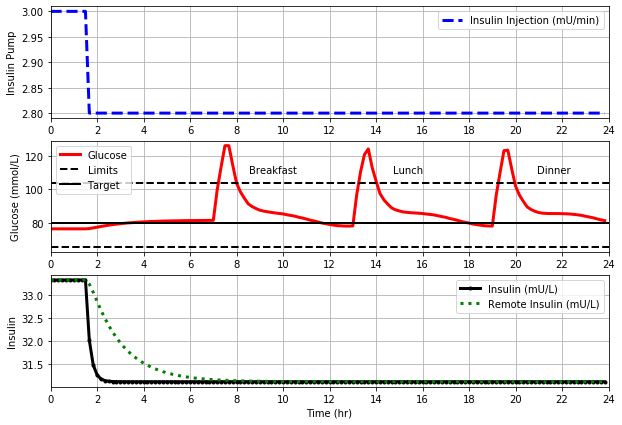

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def diabetic(y,t,ui,d):
    # Inputs (2)
    # U = Insulin infusion rate (mU/min)
    # D = Meal disturbance (mmol/L-min)

    # Expanded Bergman Minimal model to include meals and insulin
    # Parameters for an insulin dependent type-I diabetic

    # States (6):
    # In non-diabetic patients, the body maintains the blood glucose
    #  level at a range between about 3.6 and 5.8 mmol/L (64.8 and
    #  104.4 mg/dL with 1:18 conversion between mmol/L and mg/dL)
    g = y[0]                # blood glucose (mg/dL)
    x = y[1]                # remote insulin (micro-u/ml)
    i = y[2]                # insulin (micro-u/ml)
    q1 = y[3]
    q2 = y[4]
    g_gut = y[5]            # gut blood glucose (mg/dl)

    # Parameters:
    gb    = 291.0           # Basal Blood Glucose (mg/dL)
    p1    = 3.17e-2         # 1/min
    p2    = 1.23e-2         # 1/min
    si    = 2.9e-2          # 1/min * (mL/micro-U)
    ke    = 9.0e-2          # 1/min
    kabs  = 1.2e-2          # 1/min
    kemp  = 1.8e-1          # 1/min
    f     = 8.00e-1         # L
    vi    = 12.0            # L
    vg    = 12.0            # L

    # Compute ydot:
    dydt = np.empty(6)
    dydt[0] = -p1*(g-gb) - si*x*g + f*kabs/vg * g_gut + f/vg * d
    dydt[1] =  p2*(i-x) # remote insulin compartment dynamics
    dydt[2] = -ke*i + ui # insulin dynamics
    dydt[3] = ui - kemp * q1
    dydt[4] = -kemp*(q2-q1)
    dydt[5] = kemp*q2 - kabs*g_gut

    # convert from minutes to hours
    dydt = dydt*60
    return dydt

# Steady State Initial Conditions for the States
y0 = np.array([76.22, 33.33, 33.33,16.67,16.67,250.0])

# Steady State Initial Condition for the Control
u_ss = 3.0 # mU/min

# Steady State for the Disturbance
d_ss = 1000.0 # mmol/L-min

# Final Time (hr)
tf = 24      # simulate for 24 hours
ns = tf*6+1  # sample time = 10 min

# Time Interval (min)
t = np.linspace(0,tf,ns)

# Store results for plotting
G = np.ones(len(t)) * y0[0]
X = np.ones(len(t)) * y0[1]
I = np.ones(len(t)) * y0[2]
u = np.ones(len(t)) * u_ss
d = np.ones(len(t)) * d_ss

# Step response for insulin
u[10:] = 2.8

# Add meal disturbances
meals = [1259,1451,1632,1632,1468,1314,1240,1187,1139,1116,\
          1099,1085,1077,1071,1066,1061,1057,1053,1046,1040,\
          1034,1025,1018,1010,1000,993,985,976,970,964,958,\
          954,952,950,950,951,1214,1410,1556,1603,1445,1331,\
          1226,1173,1136,1104,1088,1078,1070,1066,1063,1061,\
          1059,1056,1052,1048,1044,1037,1030,1024,1014,1007,\
          999,989,982,975,967,962,957,953,951,950,1210,1403,\
          1588,1593,1434,1287,1212,1159,1112,1090,1075,1064,\
          1059,1057,1056,1056,1056,1055,1054,1052,1049,1045,\
          1041,1033,1027,1020,1011,1003,996,986]
for i in range(len(meals)):
    d[i+43] = meals[i]

# Create plot
plt.figure(figsize=(10,7))

# Animating plot slows down script
animate = False # True
if animate:
    plt.ion()
    plt.show()

# Simulate Type-I Diabetic Blood Glucose
for i in range(len(t)-1):
    ts = [t[i],t[i+1]]
    y = odeint(diabetic,y0,ts,args=(u[i+1],d[i+1]))
    G[i+1] = y[-1][0]
    X[i+1] = y[-1][1]
    I[i+1] = y[-1][2]
    y0 = y[-1]

    if animate or i==(len(t)-2):
        # clear plot if animating
        if animate:
            plt.clf()
        # plot new results
        ticks = np.linspace(0,24,13)
        ax=plt.subplot(3,1,1)
        ax.grid() # turn on grid
        plt.plot(t[0:i+1],u[0:i+1],'b--',linewidth=3)
        plt.ylabel('Insulin Pump')
        plt.legend(['Insulin Injection (mU/min)'],loc='best')
        plt.xlim([0,24])
        plt.xticks(ticks)

        ax=plt.subplot(3,1,2)
        ax.grid() # turn on grid
        plt.plot(t[0:i+1],G[0:i+1],'r-',linewidth=3,label='Glucose')
        plt.plot([0,24],[104,104],'k--',linewidth=2,label='Limits')
        plt.plot([0,24],[80,80],'k-',linewidth=2,label='Target')
        plt.plot([0,24],[65,65],'k--',linewidth=2)
        plt.ylabel('Glucose (mmol/L)')
        plt.legend(loc=2)
        plt.xlim([0,24])
        plt.xticks(ticks)
        plt.figtext(0.4, 0.55, 'Breakfast')
        plt.figtext(0.6, 0.55, 'Lunch')
        plt.figtext(0.8, 0.55, 'Dinner')

        ax=plt.subplot(3,1,3)
        ax.grid() # turn on grid
        plt.plot(t[0:i+1],I[0:i+1],'k.-',linewidth=3,label='Insulin (mU/L)')
        plt.plot(t[0:i+1],X[0:i+1],'g:',linewidth=3,label='Remote Insulin (mU/L)')
        plt.ylabel('Insulin')
        plt.xlabel('Time (hr)')
        plt.xlim([0,24])
        plt.legend(loc='best')
        plt.xticks(ticks)

        if animate:
            plt.draw()
            plt.pause(0.05)
        else:
            plt.show()


# Construct results and save data file
# Column 1 = time
# Column 2 = insulin rate
# Column 3 = blood glucose
data = np.vstack((t,u,G)) # vertical stack
data = data.T             # transpose data
np.savetxt('data.txt',data,delimiter=',')

### Determine Initial PID Tuning

Using the $K_p, \tau_p$ and $\theta_{p}$, compute the tuning parameters for a PID controller from the IMC tuning correlation. Report the tuning parameters.

### Implement PID Controller

Using $K_{c}, \tau_{I},$ and $\tau_{D}$, implement a PID with anti-reset windup. Test the disturbance rejection capability of this controller by plotting the response of the process to meal disturbances. Comment on how the nonlinear behavior of this process impacts our observed disturbance rejection performance. Turn in a plot for the default IMC parameters, along with comments.

### Tune PID Controller

Determine a best tuning by adjusting $K_{c}, \tau_{I},$ and $\tau_{D}$ until the controller response is improved (use quantitative measures like time outside the upper and lower limits). Plot the best disturbance rejection response. Turn in final plot and values of tuning parameters.

Generate Tuning Sensitivity Guide
Run six tuning cases and plot the response of each compared to the tuned controller. The first two cases should use the best $\tau_{I}$ and $\tau_{D}$ but should use double and then half of the best $K_{c}$. The next two cases should use the best $K_{c}$ and $\tau_{D}$ , but should use double and then half of the best $\tau_{I}$. The final two cases should use the best $K_{c}$ and $\tau_{I}$, but should use double and then half of the best $\tau_{D}$. Comment on how the tuning parameters interact and impact controller performance. Turn in plots along with comments. Put all trends for each parameter on one plot for the sake of direct comparison.

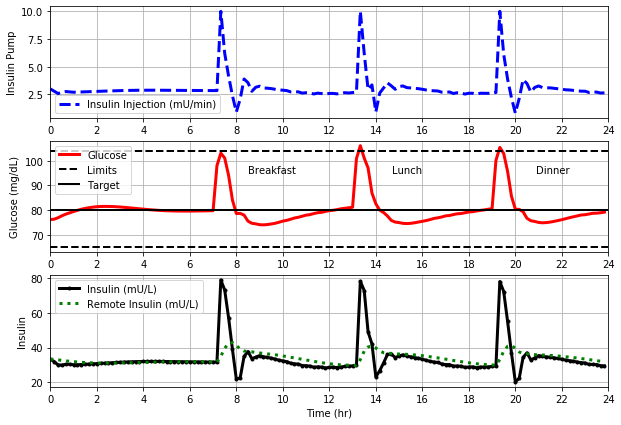

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def diabetic(y,t,ui,d):
    # Inputs (2)
    # U = Insulin infusion rate (mU/min)
    # D = Meal disturbance (mmol/L-min)

    # Expanded Bergman Minimal model to include meals and insulin
    # Parameters for an insulin dependent type-I diabetic

    # States (6):
    # In non-diabetic patients, the body maintains the blood glucose
    #  level at a range between about 3.6 and 5.8 mmol/L (64.8 and
    #  104.4 mg/dL with 1:18 conversion between mmol/L and mg/dL)
    g = y[0]                # blood glucose (mg/dL)
    x = y[1]                # remote insulin (micro-u/ml)
    i = y[2]                # insulin (micro-u/ml)
    q1 = y[3]
    q2 = y[4]
    g_gut = y[5]            # gut blood glucose (mg/dl)

    # Parameters:
    gb    = 291.0           # Basal Blood Glucose (mg/dL)
    p1    = 3.17e-2         # 1/min
    p2    = 1.23e-2         # 1/min
    si    = 2.9e-2          # 1/min * (mL/micro-U)
    ke    = 9.0e-2          # 1/min
    kabs  = 1.2e-2          # 1/min
    kemp  = 1.8e-1          # 1/min
    f     = 8.00e-1         # L
    vi    = 12.0            # L
    vg    = 12.0            # L

    # Compute ydot:
    dydt = np.empty(6)
    dydt[0] = -p1*(g-gb) - si*x*g + f*kabs/vg * g_gut + f/vg * d
    dydt[1] =  p2*(i-x) # remote insulin compartment dynamics
    dydt[2] = -ke*i + ui # insulin dynamics
    dydt[3] = ui - kemp * q1
    dydt[4] = -kemp*(q2-q1)
    dydt[5] = kemp*q2 - kabs*g_gut

    # convert from minutes to hours
    dydt = dydt*60
    return dydt

# Steady State Initial Conditions for the States
y0 = np.array([76.22, 33.33, 33.33,16.67,16.67,250.0])

# Steady State Initial Condition for the Control
u_ss = 3.0 # mU/min

# Steady State for the Disturbance
d_ss = 1000.0 # mmol/L-min

# Final Time (hr)
tf = 24      # simulate for 24 hours
ns = tf*6+1  # sample time = 10 min

# Time Interval (min)
t = np.linspace(0,tf,ns)

# Store results for plotting
G = np.ones(len(t)) * y0[0]
X = np.ones(len(t)) * y0[1]
Insulin = np.ones(len(t)) * y0[2]
u = np.ones(len(t)) * u_ss
d = np.ones(len(t)) * d_ss

# Step response for insulin
u[10:] = 2.0

# Add meal disturbances
meals = [1259,1451,1632,1632,1468,1314,1240,1187,1139,1116,\
          1099,1085,1077,1071,1066,1061,1057,1053,1046,1040,\
          1034,1025,1018,1010,1000,993,985,976,970,964,958,\
          954,952,950,950,951,1214,1410,1556,1603,1445,1331,\
          1226,1173,1136,1104,1088,1078,1070,1066,1063,1061,\
          1059,1056,1052,1048,1044,1037,1030,1024,1014,1007,\
          999,989,982,975,967,962,957,953,951,950,1210,1403,\
          1588,1593,1434,1287,1212,1159,1112,1090,1075,1064,\
          1059,1057,1056,1056,1056,1055,1054,1052,1049,1045,\
          1041,1033,1027,1020,1011,1003,996,986]
for i in range(len(meals)):
    d[i+43] = meals[i]

# Create plot
plt.figure(figsize=(10,7))

# Animating plot slows down script
animate = False # True
if animate:
    plt.ion()
    plt.show()

# storage for recording values
op = np.ones(ns+1)*u[0]  # controller output
pv = np.zeros(ns+1)  # process variable
e = np.zeros(ns+1)   # error
ie = np.zeros(ns+1)  # integral of the error
dpv = np.zeros(ns+1) # derivative of the pv
P = np.zeros(ns+1)   # proportional
I = np.zeros(ns+1)   # integral
D = np.zeros(ns+1)   # derivative
sp = np.ones(ns+1) * 80  # set point

# PID (tuning)
Kc = -2.76E-02 * 2
tauI = 0.5
tauD = 1.0

# Upper and Lower limits on OP
op_hi = 10.0
op_lo = 0.0

# Simulate Type-I Diabetic Blood Glucose
for i in range(len(t)-1):
    ts = [t[i],t[i+1]]
    delta_t = t[i+1]-t[i]

    pv[i] = G[i]
    e[i] = sp[i] - pv[i]
    if i >= 1:  # calculate starting on second cycle
        dpv[i] = (pv[i]-pv[i-1])/delta_t
        ie[i] = ie[i-1] + e[i] * delta_t
    P[i] = Kc * e[i]
    I[i] = Kc/tauI * ie[i]
    D[i] = - Kc * tauD * dpv[i]
    op[i] = op[0] + P[i] + I[i] + D[i]
    if op[i] > op_hi:  # check upper limit
        op[i] = op_hi
        ie[i] = ie[i] - e[i] * delta_t # anti-reset windup
    if op[i] < op_lo:  # check lower limit
        op[i] = op_lo
        ie[i] = ie[i] - e[i] * delta_t # anti-reset windup
    u[i+1] = op[i]

    y = odeint(diabetic,y0,ts,args=(u[i+1],d[i+1]))
    G[i+1] = y[-1][0]
    X[i+1] = y[-1][1]
    Insulin[i+1] = y[-1][2]
    y0 = y[-1]

    if animate or i==(len(t)-2):
        # clear plot if animating
        if animate:
            plt.clf()
        # plot new results
        ticks = np.linspace(0,24,13)
        ax=plt.subplot(3,1,1)
        ax.grid() # turn on grid
        plt.plot(t[0:i+1],u[0:i+1],'b--',linewidth=3)
        plt.ylabel('Insulin Pump')
        plt.legend(['Insulin Injection (mU/min)'],loc='best')
        plt.xlim([0,24])
        plt.xticks(ticks)

        ax=plt.subplot(3,1,2)
        ax.grid() # turn on grid
        plt.plot(t[0:i+1],G[0:i+1],'r-',linewidth=3,label='Glucose')
        plt.plot([0,24],[104,104],'k--',linewidth=2,label='Limits')
        plt.plot([0,24],[80,80],'k-',linewidth=2,label='Target')
        plt.plot([0,24],[65,65],'k--',linewidth=2)
        plt.ylabel('Glucose (mg/dL)')
        plt.legend(loc=2)
        plt.xlim([0,24])
        plt.xticks(ticks)
        plt.figtext(0.4, 0.55, 'Breakfast')
        plt.figtext(0.6, 0.55, 'Lunch')
        plt.figtext(0.8, 0.55, 'Dinner')

        ax=plt.subplot(3,1,3)
        ax.grid() # turn on grid
        plt.plot(t[0:i+1],Insulin[0:i+1],'k.-',linewidth=3,label='Insulin (mU/L)')
        plt.plot(t[0:i+1],X[0:i+1],'g:',linewidth=3,label='Remote Insulin (mU/L)')
        plt.ylabel('Insulin')
        plt.xlabel('Time (hr)')
        plt.xlim([0,24])
        plt.legend(loc='best')
        plt.xticks(ticks)

        if animate:
            plt.draw()
            plt.pause(0.05)
        else:
            plt.show()


# Construct results and save data file
# Column 1 = time
# Column 2 = insulin rate
# Column 3 = blood glucose
data = np.vstack((t,u,G)) # vertical stack
data = data.T             # transpose data
np.savetxt('data.txt',data,delimiter=',')